# Discretization

---

In this notebook, you will deal with continuous state and action spaces by discretizing them. This will enable you to apply reinforcement learning algorithms that are only designed to work with discrete spaces.

### 1. Import the Necessary Packages

In [1]:
import sys
import gym
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

### 2. Specify the Environment, and Explore the State and Action Spaces

We'll use [OpenAI Gym](https://gym.openai.com/) environments to test and develop our algorithms. These simulate a variety of classic as well as contemporary reinforcement learning tasks.  Let's use an environment that has a continuous state space, but a discrete action space.

In [2]:
# Create an environment and set random seed
env = gym.make('MountainCar-v0')
env.seed(505)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


[505]

Run the next code cell to watch a random agent.

In [3]:
state = env.reset()
score = 0
for t in range(200):
    action = env.action_space.sample()
    env.render()
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        break 
print('Final score:', score)
env.close()

Final score: -200.0


In this notebook, you will train an agent to perform much better!  For now, we can explore the state and action spaces, as well as sample them.

In [4]:
# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

State space: Box(2,)
- low: [-1.2  -0.07]
- high: [0.6  0.07]


In [5]:
# Generate some samples from the state space 
print("State space samples:")
print(np.array([env.observation_space.sample() for i in range(10)]))

State space samples:
[[-0.622 -0.039]
 [-0.946 -0.056]
 [ 0.571 -0.034]
 [-0.233 -0.007]
 [-1.021 -0.021]
 [-0.355  0.048]
 [ 0.428 -0.065]
 [-0.285 -0.047]
 [ 0.202  0.051]
 [-0.459 -0.05 ]]


In [6]:
# Explore the action space
print("Action space:", env.action_space)

# Generate some samples from the action space
print("Action space samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

Action space: Discrete(3)
Action space samples:
[1 1 1 2 2 2 0 1 2 1]


### 3. Discretize the State Space with a Uniform Grid

We will discretize the space using a uniformly-spaced grid. Implement the following function to create such a grid, given the lower bounds (`low`), upper bounds (`high`), and number of desired `bins` along each dimension. It should return the split points for each dimension, which will be 1 less than the number of bins.

For instance, if `low = [-1.0, -5.0]`, `high = [1.0, 5.0]`, and `bins = (10, 10)`, then your function should return the following list of 2 NumPy arrays:

```
[array([-0.8, -0.6, -0.4, -0.2,  0.0,  0.2,  0.4,  0.6,  0.8]),
 array([-4.0, -3.0, -2.0, -1.0,  0.0,  1.0,  2.0,  3.0,  4.0])]
```

Note that the ends of `low` and `high` are **not** included in these split points. It is assumed that any value below the lowest split point maps to index `0` and any value above the highest split point maps to index `n-1`, where `n` is the number of bins along that dimension.

In [23]:
def create_uniform_grid(low, high, bins=(10, 10)):
    """Define a uniformly-spaced grid that can be used to discretize a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins along each corresponding dimension.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    # TODO: Implement this
    grid_a = np.linspace(low[0], high[0], num=bins[0]+1)[1:-1]
    grid_b = np.linspace(low[1], high[1], num=bins[1]+1)[1:-1]
    grid = np.vstack((grid_a, grid_b))
    for l, h, b, splits in zip(low, high, bins, grid):
        print("    [{}, {}] / {} => {}".format(l, h, b, splits))
    return grid


low = [-1.0, -5.0]
high = [1.0, 5.0]
create_uniform_grid(low, high)  # [test]

    [-1.0, 1.0] / 10 => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]


array([[-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8],
       [-4. , -3. , -2. , -1. ,  0. ,  1. ,  2. ,  3. ,  4. ]])

Now write a function that can convert samples from a continuous space into its equivalent discretized representation, given a grid like the one you created above. You can use the [`numpy.digitize()`](https://docs.scipy.org/doc/numpy-1.9.3/reference/generated/numpy.digitize.html) function for this purpose.

Assume the grid is a list of NumPy arrays containing the following split points:
```
[array([-0.8, -0.6, -0.4, -0.2,  0.0,  0.2,  0.4,  0.6,  0.8]),
 array([-4.0, -3.0, -2.0, -1.0,  0.0,  1.0,  2.0,  3.0,  4.0])]
```

Here are some potential samples and their corresponding discretized representations:
```
[-1.0 , -5.0] => [0, 0]
[-0.81, -4.1] => [0, 0]
[-0.8 , -4.0] => [1, 1]
[-0.5 ,  0.0] => [2, 5]
[ 0.2 , -1.9] => [6, 3]
[ 0.8 ,  4.0] => [9, 9]
[ 0.81,  4.1] => [9, 9]
[ 1.0 ,  5.0] => [9, 9]
```

**Note**: There may be one-off differences in binning due to floating-point inaccuracies when samples are close to grid boundaries, but that is alright.

In [24]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    # TODO: Implement this
    index1 = np.digitize(sample[0], grid[0])
    index2 = np.digitize(sample[1], grid[1])
    index = np.hstack((index1, index2))
    return index


# Test with a simple grid and some samples
grid = create_uniform_grid([-1.0, -5.0], [1.0, 5.0])
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])
discretized_samples = np.array([discretize(sample, grid) for sample in samples])
print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep="\n")

    [-1.0, 1.0] / 10 => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]

Samples:
array([[-1.  , -5.  ],
       [-0.81, -4.1 ],
       [-0.8 , -4.  ],
       [-0.5 ,  0.  ],
       [ 0.2 , -1.9 ],
       [ 0.8 ,  4.  ],
       [ 0.81,  4.1 ],
       [ 1.  ,  5.  ]])

Discretized samples:
array([[0, 0],
       [0, 0],
       [1, 1],
       [2, 5],
       [5, 3],
       [9, 9],
       [9, 9],
       [9, 9]], dtype=int64)


### 4. Visualization

It might be helpful to visualize the original and discretized samples to get a sense of how much error you are introducing.

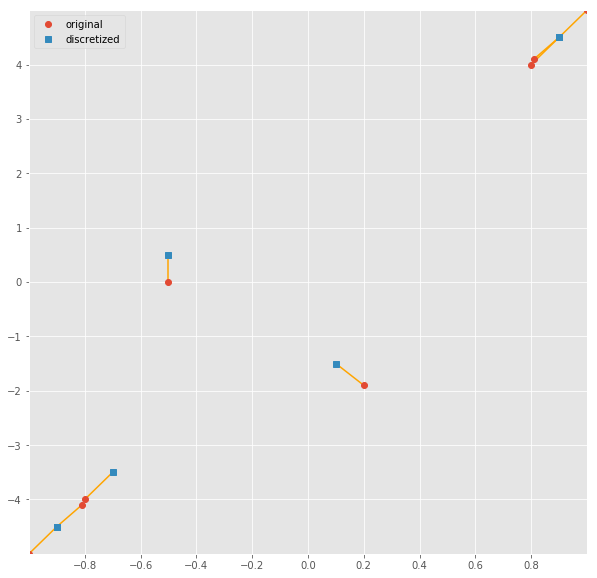

In [25]:
import matplotlib.collections as mc

def visualize_samples(samples, discretized_samples, grid, low=None, high=None):
    """Visualize original and discretized samples on a given 2-dimensional grid."""

    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Otherwise use first, last grid locations as low, high (for further mapping discretized samples)
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]

    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples

    ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
    ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
    ax.legend(['original', 'discretized'])

    
visualize_samples(samples, discretized_samples, grid, low, high)

Now that we have a way to discretize a state space, let's apply it to our reinforcement learning environment.

In [26]:
# Create a grid to discretize the state space
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(10, 10))
state_grid

    [-1.2000000476837158, 0.6000000238418579] / 10 => [-1.02 -0.84 -0.66 -0.48 -0.3  -0.12  0.06  0.24  0.42]
    [-0.07000000029802322, 0.07000000029802322] / 10 => [-0.056 -0.042 -0.028 -0.014  0.     0.014  0.028  0.042  0.056]


array([[-1.02 , -0.84 , -0.66 , -0.48 , -0.3  , -0.12 ,  0.06 ,  0.24 ,  0.42 ],
       [-0.056, -0.042, -0.028, -0.014,  0.   ,  0.014,  0.028,  0.042,  0.056]])

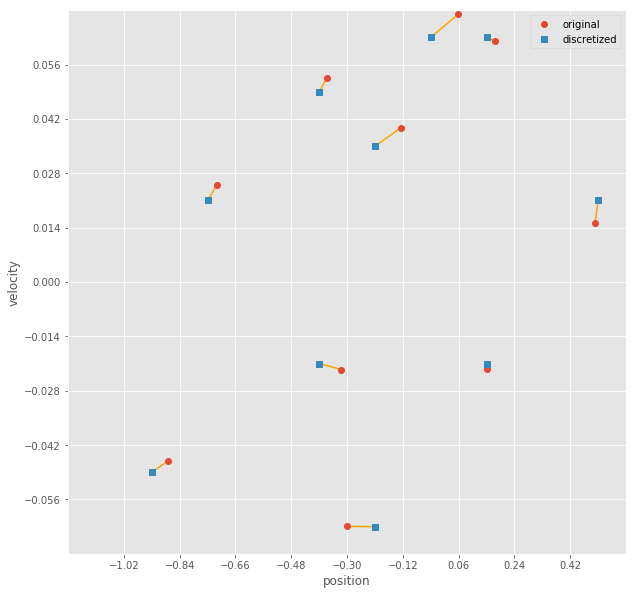

In [27]:
# Obtain some samples from the space, discretize them, and then visualize them
state_samples = np.array([env.observation_space.sample() for i in range(10)])
discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])
visualize_samples(state_samples, discretized_state_samples, state_grid,
                  env.observation_space.low, env.observation_space.high)
plt.xlabel('position'); plt.ylabel('velocity');  # axis labels for MountainCar-v0 state space

You might notice that if you have enough bins, the discretization doesn't introduce too much error into your representation.  So we may be able to now apply a reinforcement learning algorithm (like Q-Learning) that operates on discrete spaces.  Give it a shot to see how well it works!

### 5. Q-Learning

Provided below is a simple Q-Learning agent. Implement the `preprocess_state()` method to convert each continuous state sample to its corresponding discretized representation.

In [31]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, state_grid, alpha=0.02, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=505):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)  # n-dimensional state space
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space size:", self.state_size)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
        
        # Create Q-table
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("Q table size:", self.q_table.shape)

    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        # TODO: Implement this
        return tuple(discretize(state, self.state_grid))

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)

        # Decide initial action
        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        state = self.preprocess_state(state)
        if mode == 'test':
            # Test mode: Simply produce an action
            action = np.argmax(self.q_table[state])
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward
            self.q_table[self.last_state + (self.last_action,)] += self.alpha * \
                (reward + self.gamma * max(self.q_table[state]) - self.q_table[self.last_state + (self.last_action,)])

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                action = np.argmax(self.q_table[state])

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

    
q_agent = QLearningAgent(env, state_grid)

Environment: <TimeLimit<MountainCarEnv<MountainCar-v0>>>
State space size: (10, 10)
Action space size: 3
Q table size: (10, 10, 3)


Let's also define a convenience function to run an agent on a given environment.  When calling this function, you can pass in `mode='test'` to tell the agent not to learn.

In [32]:
def run(agent, env, num_episodes=20000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        # Save final score
        scores.append(total_reward)
        
        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score

            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()

    return scores

scores = run(q_agent, env)

Episode 100/20000 | Max Average Score: -inf

Episode 200/20000 | Max Average Score: -200.0

Episode 300/20000 | Max Average Score: -200.0

Episode 400/20000 | Max Average Score: -200.0

Episode 500/20000 | Max Average Score: -200.0

Episode 600/20000 | Max Average Score: -200.0

Episode 700/20000 | Max Average Score: -200.0

Episode 800/20000 | Max Average Score: -200.0

Episode 900/20000 | Max Average Score: -200.0

Episode 1000/20000 | Max Average Score: -200.0

Episode 1100/20000 | Max Average Score: -200.0

Episode 1200/20000 | Max Average Score: -200.0

Episode 1300/20000 | Max Average Score: -200.0

Episode 1400/20000 | Max Average Score: -200.0

Episode 1500/20000 | Max Average Score: -200.0

Episode 1600/20000 | Max Average Score: -199.75

Episode 1700/20000 | Max Average Score: -199.53

Episode 1800/20000 | Max Average Score: -199.4

Episode 1900/20000 | Max Average Score: -199.4

Episode 2000/20000 | Max Average Score: -199.21

Episode 2100/20000 | Max Average Score: -199.21

Episode 2200/20000 | Max Average Score: -198.84

Episode 2300/20000 | Max Average Score: -198.72

Episode 2400/20000 | Max Average Score: -198.3

Episode 2500/20000 | Max Average Score: -196.29

Episode 2600/20000 | Max Average Score: -177.92

Episode 2700/20000 | Max Average Score: -176.23

Episode 2800/20000 | Max Average Score: -176.23

Episode 2900/20000 | Max Average Score: -176.23

Episode 3000/20000 | Max Average Score: -176.23

Episode 3100/20000 | Max Average Score: -176.23

Episode 3200/20000 | Max Average Score: -176.23

Episode 3300/20000 | Max Average Score: -176.23

Episode 3400/20000 | Max Average Score: -176.12

Episode 3500/20000 | Max Average Score: -164.95

Episode 3600/20000 | Max Average Score: -164.63

Episode 3700/20000 | Max Average Score: -164.63

Episode 3800/20000 | Max Average Score: -164.63

Episode 3900/20000 | Max Average Score: -164.63

Episode 4000/20000 | Max Average Score: -164.63

Episode 4100/20000 | Max Average Score: -164.63

Episode 4200/20000 | Max Average Score: -164.63

Episode 4300/20000 | Max Average Score: -164.63

Episode 4400/20000 | Max Average Score: -164.63

Episode 4500/20000 | Max Average Score: -164.63

Episode 4600/20000 | Max Average Score: -164.63

Episode 4700/20000 | Max Average Score: -164.63

Episode 4800/20000 | Max Average Score: -164.63

Episode 4900/20000 | Max Average Score: -164.63

Episode 5000/20000 | Max Average Score: -164.63

Episode 5100/20000 | Max Average Score: -164.63

Episode 5200/20000 | Max Average Score: -164.63

Episode 5300/20000 | Max Average Score: -164.63

Episode 5400/20000 | Max Average Score: -164.63

Episode 5500/20000 | Max Average Score: -164.63

Episode 5600/20000 | Max Average Score: -164.63

Episode 5700/20000 | Max Average Score: -164.63

Episode 5800/20000 | Max Average Score: -164.63

Episode 5900/20000 | Max Average Score: -164.63

Episode 6000/20000 | Max Average Score: -164.63

Episode 6100/20000 | Max Average Score: -161.84

Episode 6200/20000 | Max Average Score: -161.84

Episode 6300/20000 | Max Average Score: -161.84

Episode 6400/20000 | Max Average Score: -157.73

Episode 6500/20000 | Max Average Score: -156.39

Episode 6600/20000 | Max Average Score: -156.39

Episode 6700/20000 | Max Average Score: -156.39

Episode 6800/20000 | Max Average Score: -156.39

Episode 6900/20000 | Max Average Score: -156.39

Episode 7000/20000 | Max Average Score: -156.39

Episode 7100/20000 | Max Average Score: -156.39

Episode 7200/20000 | Max Average Score: -156.39

Episode 7300/20000 | Max Average Score: -156.39

Episode 7400/20000 | Max Average Score: -156.39

Episode 7500/20000 | Max Average Score: -156.39

Episode 7600/20000 | Max Average Score: -156.39

Episode 7700/20000 | Max Average Score: -156.39

Episode 7800/20000 | Max Average Score: -156.39

Episode 7900/20000 | Max Average Score: -156.39

Episode 8000/20000 | Max Average Score: -156.39

Episode 8100/20000 | Max Average Score: -156.39

Episode 8200/20000 | Max Average Score: -156.39

Episode 8300/20000 | Max Average Score: -156.39

Episode 8400/20000 | Max Average Score: -156.39

Episode 8500/20000 | Max Average Score: -156.39

Episode 8600/20000 | Max Average Score: -156.39

Episode 8700/20000 | Max Average Score: -156.39

Episode 8800/20000 | Max Average Score: -156.39

Episode 8900/20000 | Max Average Score: -153.6

Episode 9000/20000 | Max Average Score: -152.22

Episode 9100/20000 | Max Average Score: -152.22

Episode 9200/20000 | Max Average Score: -152.22

Episode 9300/20000 | Max Average Score: -152.22

Episode 9400/20000 | Max Average Score: -152.22

Episode 9500/20000 | Max Average Score: -152.22

Episode 9600/20000 | Max Average Score: -152.22

Episode 9700/20000 | Max Average Score: -152.22

Episode 9800/20000 | Max Average Score: -152.22

Episode 9900/20000 | Max Average Score: -152.22

Episode 10000/20000 | Max Average Score: -152.22

Episode 10100/20000 | Max Average Score: -152.22

Episode 10200/20000 | Max Average Score: -152.22

Episode 10300/20000 | Max Average Score: -152.22

Episode 10400/20000 | Max Average Score: -152.22

Episode 10500/20000 | Max Average Score: -152.22

Episode 10600/20000 | Max Average Score: -152.22

Episode 10700/20000 | Max Average Score: -152.22

Episode 10800/20000 | Max Average Score: -152.22

Episode 10900/20000 | Max Average Score: -152.22

Episode 11000/20000 | Max Average Score: -152.22

Episode 11100/20000 | Max Average Score: -152.22

Episode 11200/20000 | Max Average Score: -152.22

Episode 11300/20000 | Max Average Score: -152.22

Episode 11400/20000 | Max Average Score: -152.22

Episode 11500/20000 | Max Average Score: -152.22

Episode 11600/20000 | Max Average Score: -151.71

Episode 11700/20000 | Max Average Score: -151.52

Episode 11800/20000 | Max Average Score: -151.52

Episode 11900/20000 | Max Average Score: -151.52

Episode 12000/20000 | Max Average Score: -151.52

Episode 12100/20000 | Max Average Score: -151.52

Episode 12200/20000 | Max Average Score: -151.52

Episode 12300/20000 | Max Average Score: -151.52

Episode 12400/20000 | Max Average Score: -151.52

Episode 12500/20000 | Max Average Score: -151.52

Episode 12600/20000 | Max Average Score: -151.52

Episode 12700/20000 | Max Average Score: -151.52

Episode 12800/20000 | Max Average Score: -151.52

Episode 12900/20000 | Max Average Score: -151.52

Episode 13000/20000 | Max Average Score: -151.52

Episode 13100/20000 | Max Average Score: -151.52

Episode 13200/20000 | Max Average Score: -151.52

Episode 13300/20000 | Max Average Score: -151.52

Episode 13400/20000 | Max Average Score: -151.52

Episode 13500/20000 | Max Average Score: -151.52

Episode 13600/20000 | Max Average Score: -151.52

Episode 13700/20000 | Max Average Score: -151.52

Episode 13800/20000 | Max Average Score: -151.52

Episode 13900/20000 | Max Average Score: -151.52

Episode 14000/20000 | Max Average Score: -151.52

Episode 14100/20000 | Max Average Score: -151.52

Episode 14200/20000 | Max Average Score: -151.52

Episode 14300/20000 | Max Average Score: -151.52

Episode 14400/20000 | Max Average Score: -151.52

Episode 14500/20000 | Max Average Score: -151.52

Episode 14600/20000 | Max Average Score: -151.52

Episode 14700/20000 | Max Average Score: -151.52

Episode 14800/20000 | Max Average Score: -151.52

Episode 14900/20000 | Max Average Score: -151.52

Episode 15000/20000 | Max Average Score: -151.52

Episode 15100/20000 | Max Average Score: -151.52

Episode 15200/20000 | Max Average Score: -151.52

Episode 15300/20000 | Max Average Score: -151.52

Episode 15400/20000 | Max Average Score: -151.52

Episode 15500/20000 | Max Average Score: -151.52

Episode 15600/20000 | Max Average Score: -151.52

Episode 15700/20000 | Max Average Score: -151.52

Episode 15800/20000 | Max Average Score: -151.52

Episode 15900/20000 | Max Average Score: -150.5

Episode 16000/20000 | Max Average Score: -148.42

Episode 16100/20000 | Max Average Score: -148.42

Episode 16200/20000 | Max Average Score: -148.42

Episode 16300/20000 | Max Average Score: -148.42

Episode 16400/20000 | Max Average Score: -148.42

Episode 16500/20000 | Max Average Score: -148.42

Episode 16600/20000 | Max Average Score: -148.42

Episode 16700/20000 | Max Average Score: -148.42

Episode 16800/20000 | Max Average Score: -148.42

Episode 16900/20000 | Max Average Score: -148.42

Episode 17000/20000 | Max Average Score: -148.42

Episode 17100/20000 | Max Average Score: -148.42

Episode 17200/20000 | Max Average Score: -148.42

Episode 17300/20000 | Max Average Score: -148.42

Episode 17400/20000 | Max Average Score: -148.42

Episode 17500/20000 | Max Average Score: -148.42

Episode 17600/20000 | Max Average Score: -148.42

Episode 17700/20000 | Max Average Score: -148.42

Episode 17800/20000 | Max Average Score: -148.42

Episode 17900/20000 | Max Average Score: -148.42

Episode 18000/20000 | Max Average Score: -148.42

Episode 18100/20000 | Max Average Score: -148.42

Episode 18200/20000 | Max Average Score: -148.42

Episode 18300/20000 | Max Average Score: -148.42

Episode 18400/20000 | Max Average Score: -148.42

Episode 18500/20000 | Max Average Score: -148.42

Episode 18600/20000 | Max Average Score: -148.42

Episode 18700/20000 | Max Average Score: -148.42

Episode 18800/20000 | Max Average Score: -148.42

Episode 18900/20000 | Max Average Score: -148.42

Episode 19000/20000 | Max Average Score: -148.42

Episode 19100/20000 | Max Average Score: -148.42

Episode 19200/20000 | Max Average Score: -148.42

Episode 19300/20000 | Max Average Score: -148.42

Episode 19400/20000 | Max Average Score: -148.42

Episode 19500/20000 | Max Average Score: -148.42

Episode 19600/20000 | Max Average Score: -148.42

Episode 19700/20000 | Max Average Score: -148.42

Episode 19800/20000 | Max Average Score: -148.42

Episode 19900/20000 | Max Average Score: -148.42

Episode 20000/20000 | Max Average Score: -148.42

The best way to analyze if your agent was learning the task is to plot the scores. It should generally increase as the agent goes through more episodes.

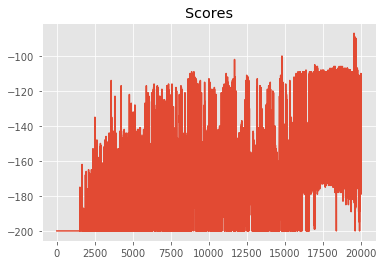

In [33]:
# Plot scores obtained per episode
plt.plot(scores); plt.title("Scores");

If the scores are noisy, it might be difficult to tell whether your agent is actually learning. To find the underlying trend, you may want to plot a rolling mean of the scores. Let's write a convenience function to plot both raw scores as well as a rolling mean.

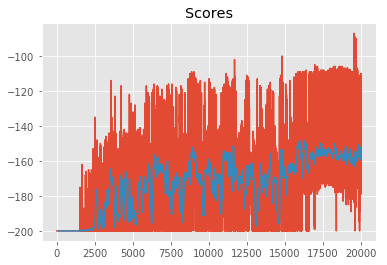

In [34]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores)

You should observe the mean episode scores go up over time. Next, you can freeze learning and run the agent in test mode to see how well it performs.

[TEST] Completed 100 episodes with avg. score = -157.46


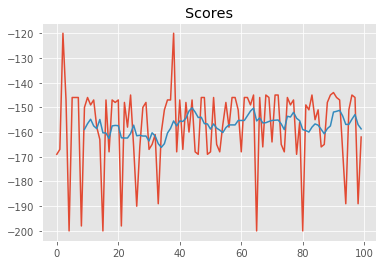

In [35]:
# Run in test mode and analyze scores obtained
test_scores = run(q_agent, env, num_episodes=100, mode='test')
print("[TEST] Completed {} episodes with avg. score = {}".format(len(test_scores), np.mean(test_scores)))
_ = plot_scores(test_scores, rolling_window=10)

It's also interesting to look at the final Q-table that is learned by the agent. Note that the Q-table is of size MxNxA, where (M, N) is the size of the state space, and A is the size of the action space. We are interested in the maximum Q-value for each state, and the corresponding (best) action associated with that value.

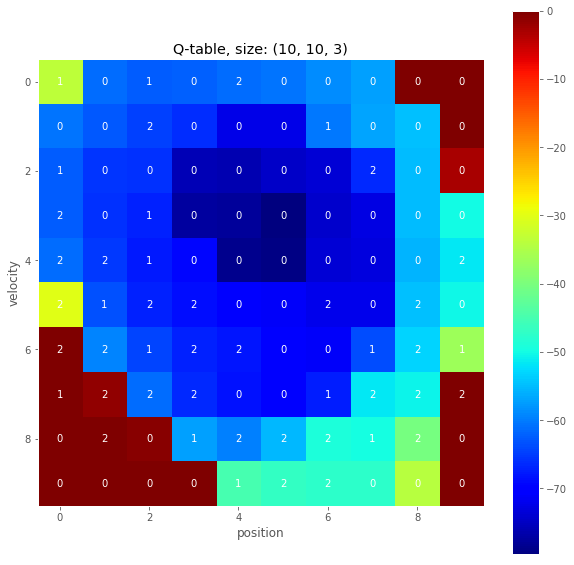

In [36]:
def plot_q_table(q_table):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)       # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='jet');
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, q_actions[x, y], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')


plot_q_table(q_agent.q_table)

### 6. Modify the Grid

Now it's your turn to play with the grid definition and see what gives you optimal results. Your agent's final performance is likely to get better if you use a finer grid, with more bins per dimension, at the cost of higher model complexity (more parameters to learn).

In [41]:
# TODO: Create a new agent with a different state space grid
state_grid_new = create_uniform_grid(low, high, bins=(20, 20))
q_agent_new = QLearningAgent(env, state_grid_new)
q_agent_new.scores = []  # initialize a list to store scores for this agent

    [-1.0, 1.0] / 20 => [-0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9]
    [-5.0, 5.0] / 20 => [-4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5]
Environment: <TimeLimit<MountainCarEnv<MountainCar-v0>>>
State space size: (20, 20)
Action space size: 3
Q table size: (20, 20, 3)


Episode 100/50000 | Max Average Score: -inf

Episode 200/50000 | Max Average Score: -200.0

Episode 300/50000 | Max Average Score: -200.0

Episode 400/50000 | Max Average Score: -200.0

Episode 500/50000 | Max Average Score: -200.0

Episode 600/50000 | Max Average Score: -200.0

Episode 700/50000 | Max Average Score: -200.0

Episode 800/50000 | Max Average Score: -200.0

Episode 900/50000 | Max Average Score: -200.0

Episode 1000/50000 | Max Average Score: -200.0

Episode 1100/50000 | Max Average Score: -200.0

Episode 1200/50000 | Max Average Score: -200.0

Episode 1300/50000 | Max Average Score: -200.0

Episode 1400/50000 | Max Average Score: -200.0

Episode 1500/50000 | Max Average Score: -200.0

Episode 1600/50000 | Max Average Score: -200.0

Episode 1700/50000 | Max Average Score: -200.0

Episode 1800/50000 | Max Average Score: -199.67

Episode 1900/50000 | Max Average Score: -198.7

Episode 2000/50000 | Max Average Score: -198.7

Episode 2100/50000 | Max Average Score: -198.7

Episode 2200/50000 | Max Average Score: -198.7

Episode 2300/50000 | Max Average Score: -198.7

Episode 2400/50000 | Max Average Score: -198.7

Episode 2500/50000 | Max Average Score: -198.7

Episode 2600/50000 | Max Average Score: -198.7

Episode 2700/50000 | Max Average Score: -198.7

Episode 2800/50000 | Max Average Score: -198.7

Episode 2900/50000 | Max Average Score: -198.7

Episode 3000/50000 | Max Average Score: -198.7

Episode 3100/50000 | Max Average Score: -198.7

Episode 3200/50000 | Max Average Score: -198.7

Episode 3300/50000 | Max Average Score: -198.7

Episode 3400/50000 | Max Average Score: -198.7

Episode 3500/50000 | Max Average Score: -198.7

Episode 3600/50000 | Max Average Score: -198.7

Episode 3700/50000 | Max Average Score: -198.7

Episode 3800/50000 | Max Average Score: -198.7

Episode 3900/50000 | Max Average Score: -198.7

Episode 4000/50000 | Max Average Score: -198.7

Episode 4100/50000 | Max Average Score: -198.7

Episode 4200/50000 | Max Average Score: -198.7

Episode 4300/50000 | Max Average Score: -198.7

Episode 4400/50000 | Max Average Score: -198.7

Episode 4500/50000 | Max Average Score: -198.7

Episode 4600/50000 | Max Average Score: -198.7

Episode 4700/50000 | Max Average Score: -198.7

Episode 4800/50000 | Max Average Score: -198.7

Episode 4900/50000 | Max Average Score: -198.7

Episode 5000/50000 | Max Average Score: -198.7

Episode 5100/50000 | Max Average Score: -198.7

Episode 5200/50000 | Max Average Score: -198.7

Episode 5300/50000 | Max Average Score: -198.7

Episode 5400/50000 | Max Average Score: -198.7

Episode 5500/50000 | Max Average Score: -197.59

Episode 5600/50000 | Max Average Score: -196.02

Episode 5700/50000 | Max Average Score: -196.02

Episode 5800/50000 | Max Average Score: -196.02

Episode 5900/50000 | Max Average Score: -196.02

Episode 6000/50000 | Max Average Score: -196.02

Episode 6100/50000 | Max Average Score: -196.02

Episode 6200/50000 | Max Average Score: -194.67

Episode 6300/50000 | Max Average Score: -192.39

Episode 6400/50000 | Max Average Score: -192.39

Episode 6500/50000 | Max Average Score: -192.39

Episode 6600/50000 | Max Average Score: -192.39

Episode 6700/50000 | Max Average Score: -192.39

Episode 6800/50000 | Max Average Score: -192.39

Episode 6900/50000 | Max Average Score: -192.39

Episode 7000/50000 | Max Average Score: -192.39

Episode 7100/50000 | Max Average Score: -192.39

Episode 7200/50000 | Max Average Score: -192.39

Episode 7300/50000 | Max Average Score: -192.39

Episode 7400/50000 | Max Average Score: -192.39

Episode 7500/50000 | Max Average Score: -192.39

Episode 7600/50000 | Max Average Score: -192.39

Episode 7700/50000 | Max Average Score: -192.39

Episode 7800/50000 | Max Average Score: -192.39

Episode 7900/50000 | Max Average Score: -190.34

Episode 8000/50000 | Max Average Score: -181.49

Episode 8100/50000 | Max Average Score: -181.49

Episode 8200/50000 | Max Average Score: -181.49

Episode 8300/50000 | Max Average Score: -181.49

Episode 8400/50000 | Max Average Score: -181.49

Episode 8500/50000 | Max Average Score: -181.49

Episode 8600/50000 | Max Average Score: -181.49

Episode 8700/50000 | Max Average Score: -181.49

Episode 8800/50000 | Max Average Score: -181.49

Episode 8900/50000 | Max Average Score: -181.49

Episode 9000/50000 | Max Average Score: -181.49

Episode 9100/50000 | Max Average Score: -181.49

Episode 9200/50000 | Max Average Score: -181.49

Episode 9300/50000 | Max Average Score: -181.49

Episode 9400/50000 | Max Average Score: -181.49

Episode 9500/50000 | Max Average Score: -181.49

Episode 9600/50000 | Max Average Score: -181.49

Episode 9700/50000 | Max Average Score: -181.49

Episode 9800/50000 | Max Average Score: -181.49

Episode 9900/50000 | Max Average Score: -181.49

Episode 10000/50000 | Max Average Score: -181.49

Episode 10100/50000 | Max Average Score: -181.49

Episode 10200/50000 | Max Average Score: -181.49

Episode 10300/50000 | Max Average Score: -181.49

Episode 10400/50000 | Max Average Score: -181.49

Episode 10500/50000 | Max Average Score: -181.49

Episode 10600/50000 | Max Average Score: -181.49

Episode 10700/50000 | Max Average Score: -181.49

Episode 10800/50000 | Max Average Score: -181.49

Episode 10900/50000 | Max Average Score: -181.49

Episode 11000/50000 | Max Average Score: -181.49

Episode 11100/50000 | Max Average Score: -181.49

Episode 11200/50000 | Max Average Score: -181.49

Episode 11300/50000 | Max Average Score: -181.49

Episode 11400/50000 | Max Average Score: -181.49

Episode 11500/50000 | Max Average Score: -181.49

Episode 11600/50000 | Max Average Score: -181.49

Episode 11700/50000 | Max Average Score: -181.49

Episode 11800/50000 | Max Average Score: -181.49

Episode 11900/50000 | Max Average Score: -181.49

Episode 12000/50000 | Max Average Score: -181.49

Episode 12100/50000 | Max Average Score: -181.49

Episode 12200/50000 | Max Average Score: -181.49

Episode 12300/50000 | Max Average Score: -181.49

Episode 12400/50000 | Max Average Score: -181.49

Episode 12500/50000 | Max Average Score: -181.49

Episode 12600/50000 | Max Average Score: -181.49

Episode 12700/50000 | Max Average Score: -181.49

Episode 12800/50000 | Max Average Score: -181.49

Episode 12900/50000 | Max Average Score: -181.49

Episode 13000/50000 | Max Average Score: -181.49

Episode 13100/50000 | Max Average Score: -181.49

Episode 13200/50000 | Max Average Score: -181.49

Episode 13300/50000 | Max Average Score: -181.49

Episode 13400/50000 | Max Average Score: -181.49

Episode 13500/50000 | Max Average Score: -181.49

Episode 13600/50000 | Max Average Score: -181.49

Episode 13700/50000 | Max Average Score: -181.49

Episode 13800/50000 | Max Average Score: -181.49

Episode 13900/50000 | Max Average Score: -181.49

Episode 14000/50000 | Max Average Score: -181.49

Episode 14100/50000 | Max Average Score: -181.49

Episode 14200/50000 | Max Average Score: -181.49

Episode 14300/50000 | Max Average Score: -181.49

Episode 14400/50000 | Max Average Score: -181.49

Episode 14500/50000 | Max Average Score: -181.49

Episode 14600/50000 | Max Average Score: -181.49

Episode 14700/50000 | Max Average Score: -181.49

Episode 14800/50000 | Max Average Score: -181.49

Episode 14900/50000 | Max Average Score: -181.49

Episode 15000/50000 | Max Average Score: -181.49

Episode 15100/50000 | Max Average Score: -181.49

Episode 15200/50000 | Max Average Score: -181.49

Episode 15300/50000 | Max Average Score: -181.49

Episode 15400/50000 | Max Average Score: -181.49

Episode 15500/50000 | Max Average Score: -181.49

Episode 15600/50000 | Max Average Score: -181.49

Episode 15700/50000 | Max Average Score: -181.49

Episode 15800/50000 | Max Average Score: -181.49

Episode 15900/50000 | Max Average Score: -181.49

Episode 16000/50000 | Max Average Score: -181.49

Episode 16100/50000 | Max Average Score: -181.49

Episode 16200/50000 | Max Average Score: -181.49

Episode 16300/50000 | Max Average Score: -181.49

Episode 16400/50000 | Max Average Score: -181.49

Episode 16500/50000 | Max Average Score: -181.49

Episode 16600/50000 | Max Average Score: -181.49

Episode 16700/50000 | Max Average Score: -181.49

Episode 16800/50000 | Max Average Score: -181.49

Episode 16900/50000 | Max Average Score: -181.49

Episode 17000/50000 | Max Average Score: -181.49

Episode 17100/50000 | Max Average Score: -181.49

Episode 17200/50000 | Max Average Score: -181.49

Episode 17300/50000 | Max Average Score: -181.49

Episode 17400/50000 | Max Average Score: -181.49

Episode 17500/50000 | Max Average Score: -181.49

Episode 17600/50000 | Max Average Score: -181.49

Episode 17700/50000 | Max Average Score: -181.49

Episode 17800/50000 | Max Average Score: -181.49

Episode 17900/50000 | Max Average Score: -181.49

Episode 18000/50000 | Max Average Score: -181.49

Episode 18100/50000 | Max Average Score: -181.49

Episode 18200/50000 | Max Average Score: -181.49

Episode 18300/50000 | Max Average Score: -181.49

Episode 18400/50000 | Max Average Score: -181.49

Episode 18500/50000 | Max Average Score: -181.49

Episode 18600/50000 | Max Average Score: -181.49

Episode 18700/50000 | Max Average Score: -181.49

Episode 18800/50000 | Max Average Score: -181.49

Episode 18900/50000 | Max Average Score: -181.49

Episode 19000/50000 | Max Average Score: -181.49

Episode 19100/50000 | Max Average Score: -181.49

Episode 19200/50000 | Max Average Score: -181.49

Episode 19300/50000 | Max Average Score: -181.49

Episode 19400/50000 | Max Average Score: -181.49

Episode 19500/50000 | Max Average Score: -181.49

Episode 19600/50000 | Max Average Score: -181.49

Episode 19700/50000 | Max Average Score: -181.49

Episode 19800/50000 | Max Average Score: -181.49

Episode 19900/50000 | Max Average Score: -181.49

Episode 20000/50000 | Max Average Score: -181.49

Episode 20100/50000 | Max Average Score: -181.49

Episode 20200/50000 | Max Average Score: -181.49

Episode 20300/50000 | Max Average Score: -181.49

Episode 20400/50000 | Max Average Score: -181.49

Episode 20500/50000 | Max Average Score: -181.49

Episode 20600/50000 | Max Average Score: -181.49

Episode 20700/50000 | Max Average Score: -181.49

Episode 20800/50000 | Max Average Score: -181.49

Episode 20900/50000 | Max Average Score: -181.49

Episode 21000/50000 | Max Average Score: -181.49

Episode 21100/50000 | Max Average Score: -181.49

Episode 21200/50000 | Max Average Score: -181.49

Episode 21300/50000 | Max Average Score: -181.49

Episode 21400/50000 | Max Average Score: -181.49

Episode 21500/50000 | Max Average Score: -181.49

Episode 21600/50000 | Max Average Score: -181.49

Episode 21700/50000 | Max Average Score: -181.49

Episode 21800/50000 | Max Average Score: -181.49

Episode 21900/50000 | Max Average Score: -181.49

Episode 22000/50000 | Max Average Score: -181.49

Episode 22100/50000 | Max Average Score: -181.49

Episode 22200/50000 | Max Average Score: -181.49

Episode 22300/50000 | Max Average Score: -181.49

Episode 22400/50000 | Max Average Score: -181.49

Episode 22500/50000 | Max Average Score: -181.49

Episode 22600/50000 | Max Average Score: -181.49

Episode 22700/50000 | Max Average Score: -181.49

Episode 22800/50000 | Max Average Score: -181.49

Episode 22900/50000 | Max Average Score: -181.49

Episode 23000/50000 | Max Average Score: -181.49

Episode 23100/50000 | Max Average Score: -181.49

Episode 23200/50000 | Max Average Score: -181.49

Episode 23300/50000 | Max Average Score: -181.49

Episode 23400/50000 | Max Average Score: -181.49

Episode 23500/50000 | Max Average Score: -181.49

Episode 23600/50000 | Max Average Score: -181.49

Episode 23700/50000 | Max Average Score: -181.49

Episode 23800/50000 | Max Average Score: -181.49

Episode 23900/50000 | Max Average Score: -181.49

Episode 24000/50000 | Max Average Score: -181.49

Episode 24100/50000 | Max Average Score: -181.49

Episode 24200/50000 | Max Average Score: -181.49

Episode 24300/50000 | Max Average Score: -181.49

Episode 24400/50000 | Max Average Score: -181.49

Episode 24500/50000 | Max Average Score: -181.49

Episode 24600/50000 | Max Average Score: -181.49

Episode 24700/50000 | Max Average Score: -181.49

Episode 24800/50000 | Max Average Score: -181.49

Episode 24900/50000 | Max Average Score: -181.49

Episode 25000/50000 | Max Average Score: -181.49

Episode 25100/50000 | Max Average Score: -181.49

Episode 25200/50000 | Max Average Score: -181.49

Episode 25300/50000 | Max Average Score: -181.49

Episode 25400/50000 | Max Average Score: -181.49

Episode 25500/50000 | Max Average Score: -181.49

Episode 25600/50000 | Max Average Score: -181.49

Episode 25700/50000 | Max Average Score: -181.49

Episode 25800/50000 | Max Average Score: -181.49

Episode 25900/50000 | Max Average Score: -181.49

Episode 26000/50000 | Max Average Score: -181.49

Episode 26100/50000 | Max Average Score: -181.49

Episode 26200/50000 | Max Average Score: -181.49

Episode 26300/50000 | Max Average Score: -181.49

Episode 26400/50000 | Max Average Score: -181.49

Episode 26500/50000 | Max Average Score: -181.49

Episode 26600/50000 | Max Average Score: -181.49

Episode 26700/50000 | Max Average Score: -181.49

Episode 26800/50000 | Max Average Score: -181.49

Episode 26900/50000 | Max Average Score: -181.49

Episode 27000/50000 | Max Average Score: -181.49

Episode 27100/50000 | Max Average Score: -181.49

Episode 27200/50000 | Max Average Score: -179.35

Episode 27300/50000 | Max Average Score: -179.35

Episode 27400/50000 | Max Average Score: -179.35

Episode 27500/50000 | Max Average Score: -179.35

Episode 27600/50000 | Max Average Score: -179.35

Episode 27700/50000 | Max Average Score: -179.35

Episode 27800/50000 | Max Average Score: -175.28

Episode 27900/50000 | Max Average Score: -175.28

Episode 28000/50000 | Max Average Score: -175.28

Episode 28100/50000 | Max Average Score: -175.28

Episode 28200/50000 | Max Average Score: -175.28

Episode 28300/50000 | Max Average Score: -175.28

Episode 28400/50000 | Max Average Score: -175.28

Episode 28500/50000 | Max Average Score: -174.28

Episode 28600/50000 | Max Average Score: -174.28

Episode 28700/50000 | Max Average Score: -174.28

Episode 28800/50000 | Max Average Score: -172.2

Episode 28900/50000 | Max Average Score: -172.2

Episode 29000/50000 | Max Average Score: -172.2

Episode 29100/50000 | Max Average Score: -172.2

Episode 29200/50000 | Max Average Score: -172.2

Episode 29300/50000 | Max Average Score: -172.2

Episode 29400/50000 | Max Average Score: -172.2

Episode 29500/50000 | Max Average Score: -172.2

Episode 29600/50000 | Max Average Score: -172.2

Episode 29700/50000 | Max Average Score: -172.2

Episode 29800/50000 | Max Average Score: -172.2

Episode 29900/50000 | Max Average Score: -172.2

Episode 30000/50000 | Max Average Score: -172.2

Episode 30100/50000 | Max Average Score: -172.2

Episode 30200/50000 | Max Average Score: -172.2

Episode 30300/50000 | Max Average Score: -171.4

Episode 30400/50000 | Max Average Score: -171.4

Episode 30500/50000 | Max Average Score: -171.4

Episode 30600/50000 | Max Average Score: -171.4

Episode 30700/50000 | Max Average Score: -171.4

Episode 30800/50000 | Max Average Score: -171.4

Episode 30900/50000 | Max Average Score: -171.4

Episode 31000/50000 | Max Average Score: -171.4

Episode 31100/50000 | Max Average Score: -171.4

Episode 31200/50000 | Max Average Score: -171.4

Episode 31300/50000 | Max Average Score: -171.4

Episode 31400/50000 | Max Average Score: -171.4

Episode 31500/50000 | Max Average Score: -171.4

Episode 31600/50000 | Max Average Score: -171.4

Episode 31700/50000 | Max Average Score: -171.4

Episode 31800/50000 | Max Average Score: -171.4

Episode 31900/50000 | Max Average Score: -171.4

Episode 32000/50000 | Max Average Score: -171.4

Episode 32100/50000 | Max Average Score: -171.4

Episode 32200/50000 | Max Average Score: -171.4

Episode 32300/50000 | Max Average Score: -171.4

Episode 32400/50000 | Max Average Score: -171.4

Episode 32500/50000 | Max Average Score: -171.4

Episode 32600/50000 | Max Average Score: -171.4

Episode 32700/50000 | Max Average Score: -171.4

Episode 32800/50000 | Max Average Score: -171.4

Episode 32900/50000 | Max Average Score: -171.4

Episode 33000/50000 | Max Average Score: -171.4

Episode 33100/50000 | Max Average Score: -171.4

Episode 33200/50000 | Max Average Score: -171.4

Episode 33300/50000 | Max Average Score: -171.4

Episode 33400/50000 | Max Average Score: -171.4

Episode 33500/50000 | Max Average Score: -171.4

Episode 33600/50000 | Max Average Score: -171.4

Episode 33700/50000 | Max Average Score: -171.4

Episode 33800/50000 | Max Average Score: -165.99

Episode 33900/50000 | Max Average Score: -165.99

Episode 34000/50000 | Max Average Score: -165.99

Episode 34100/50000 | Max Average Score: -165.99

Episode 34200/50000 | Max Average Score: -165.99

Episode 34300/50000 | Max Average Score: -165.99

Episode 34400/50000 | Max Average Score: -165.99

Episode 34500/50000 | Max Average Score: -162.7

Episode 34600/50000 | Max Average Score: -162.7

Episode 34700/50000 | Max Average Score: -162.34

Episode 34800/50000 | Max Average Score: -162.34

Episode 34900/50000 | Max Average Score: -162.34

Episode 35000/50000 | Max Average Score: -162.34

Episode 35100/50000 | Max Average Score: -162.34

Episode 35200/50000 | Max Average Score: -162.34

Episode 35300/50000 | Max Average Score: -162.34

Episode 35400/50000 | Max Average Score: -162.34

Episode 35500/50000 | Max Average Score: -162.34

Episode 35600/50000 | Max Average Score: -162.34

Episode 35700/50000 | Max Average Score: -162.34

Episode 35800/50000 | Max Average Score: -162.34

Episode 35900/50000 | Max Average Score: -162.34

Episode 36000/50000 | Max Average Score: -162.34

Episode 36100/50000 | Max Average Score: -161.35

Episode 36200/50000 | Max Average Score: -161.35

Episode 36300/50000 | Max Average Score: -161.35

Episode 36400/50000 | Max Average Score: -161.35

Episode 36500/50000 | Max Average Score: -161.35

Episode 36600/50000 | Max Average Score: -161.35

Episode 36700/50000 | Max Average Score: -161.35

Episode 36800/50000 | Max Average Score: -161.35

Episode 36900/50000 | Max Average Score: -161.35

Episode 37000/50000 | Max Average Score: -161.35

Episode 37100/50000 | Max Average Score: -161.35

Episode 37200/50000 | Max Average Score: -161.35

Episode 37300/50000 | Max Average Score: -161.35

Episode 37400/50000 | Max Average Score: -161.35

Episode 37500/50000 | Max Average Score: -161.35

Episode 37600/50000 | Max Average Score: -161.35

Episode 37700/50000 | Max Average Score: -161.35

Episode 37800/50000 | Max Average Score: -161.35

Episode 37900/50000 | Max Average Score: -161.35

Episode 38000/50000 | Max Average Score: -161.35

Episode 38100/50000 | Max Average Score: -161.35

Episode 38200/50000 | Max Average Score: -161.35

Episode 38300/50000 | Max Average Score: -161.35

Episode 38400/50000 | Max Average Score: -161.35

Episode 38500/50000 | Max Average Score: -161.35

Episode 38600/50000 | Max Average Score: -161.35

Episode 38700/50000 | Max Average Score: -161.35

Episode 38800/50000 | Max Average Score: -161.35

Episode 38900/50000 | Max Average Score: -161.35

Episode 39000/50000 | Max Average Score: -161.35

Episode 39100/50000 | Max Average Score: -161.35

Episode 39200/50000 | Max Average Score: -161.35

Episode 39300/50000 | Max Average Score: -161.35

Episode 39400/50000 | Max Average Score: -161.35

Episode 39500/50000 | Max Average Score: -161.35

Episode 39600/50000 | Max Average Score: -161.35

Episode 39700/50000 | Max Average Score: -161.35

Episode 39800/50000 | Max Average Score: -161.35

Episode 39900/50000 | Max Average Score: -161.35

Episode 40000/50000 | Max Average Score: -161.35

Episode 40100/50000 | Max Average Score: -161.35

Episode 40200/50000 | Max Average Score: -161.35

Episode 40300/50000 | Max Average Score: -161.35

Episode 40400/50000 | Max Average Score: -161.35

Episode 40500/50000 | Max Average Score: -161.35

Episode 40600/50000 | Max Average Score: -161.35

Episode 40700/50000 | Max Average Score: -161.35

Episode 40800/50000 | Max Average Score: -161.35

Episode 40900/50000 | Max Average Score: -161.35

Episode 41000/50000 | Max Average Score: -161.35

Episode 41100/50000 | Max Average Score: -161.35

Episode 41200/50000 | Max Average Score: -161.35

Episode 41300/50000 | Max Average Score: -161.35

Episode 41400/50000 | Max Average Score: -161.35

Episode 41500/50000 | Max Average Score: -161.35

Episode 41600/50000 | Max Average Score: -161.35

Episode 41700/50000 | Max Average Score: -161.35

Episode 41800/50000 | Max Average Score: -161.35

Episode 41900/50000 | Max Average Score: -161.35

Episode 42000/50000 | Max Average Score: -161.35

Episode 42100/50000 | Max Average Score: -161.35

Episode 42200/50000 | Max Average Score: -161.35

Episode 42300/50000 | Max Average Score: -161.35

Episode 42400/50000 | Max Average Score: -161.35

Episode 42500/50000 | Max Average Score: -161.35

Episode 42600/50000 | Max Average Score: -161.35

Episode 42700/50000 | Max Average Score: -161.35

Episode 42800/50000 | Max Average Score: -161.35

Episode 42900/50000 | Max Average Score: -161.35

Episode 43000/50000 | Max Average Score: -161.35

Episode 43100/50000 | Max Average Score: -161.35

Episode 43200/50000 | Max Average Score: -161.35

Episode 43300/50000 | Max Average Score: -161.35

Episode 43400/50000 | Max Average Score: -161.35

Episode 43500/50000 | Max Average Score: -161.35

Episode 43600/50000 | Max Average Score: -161.35

Episode 43700/50000 | Max Average Score: -161.35

Episode 43800/50000 | Max Average Score: -161.35

Episode 43900/50000 | Max Average Score: -161.35

Episode 44000/50000 | Max Average Score: -161.35

Episode 44100/50000 | Max Average Score: -161.35

Episode 44200/50000 | Max Average Score: -161.35

Episode 44300/50000 | Max Average Score: -161.35

Episode 44400/50000 | Max Average Score: -161.35

Episode 44500/50000 | Max Average Score: -161.35

Episode 44600/50000 | Max Average Score: -161.35

Episode 44700/50000 | Max Average Score: -161.35

Episode 44800/50000 | Max Average Score: -161.35

Episode 44900/50000 | Max Average Score: -161.35

Episode 45000/50000 | Max Average Score: -161.35

Episode 45100/50000 | Max Average Score: -161.35

Episode 45200/50000 | Max Average Score: -161.35

Episode 45300/50000 | Max Average Score: -161.35

Episode 45400/50000 | Max Average Score: -161.35

Episode 45500/50000 | Max Average Score: -161.35

Episode 45600/50000 | Max Average Score: -161.35

Episode 45700/50000 | Max Average Score: -161.35

Episode 45800/50000 | Max Average Score: -161.35

Episode 45900/50000 | Max Average Score: -161.35

Episode 46000/50000 | Max Average Score: -161.35

Episode 46100/50000 | Max Average Score: -161.35

Episode 46200/50000 | Max Average Score: -161.35

Episode 46300/50000 | Max Average Score: -161.35

Episode 46400/50000 | Max Average Score: -161.35

Episode 46500/50000 | Max Average Score: -161.35

Episode 46600/50000 | Max Average Score: -161.35

Episode 46700/50000 | Max Average Score: -161.35

Episode 46800/50000 | Max Average Score: -161.35

Episode 46900/50000 | Max Average Score: -161.35

Episode 47000/50000 | Max Average Score: -161.35

Episode 47100/50000 | Max Average Score: -161.35

Episode 47200/50000 | Max Average Score: -161.35

Episode 47300/50000 | Max Average Score: -161.35

Episode 47400/50000 | Max Average Score: -158.79

Episode 47500/50000 | Max Average Score: -155.86

Episode 47600/50000 | Max Average Score: -152.13

Episode 47700/50000 | Max Average Score: -150.5

Episode 47800/50000 | Max Average Score: -150.5

Episode 47900/50000 | Max Average Score: -150.5

Episode 48000/50000 | Max Average Score: -150.5

Episode 48100/50000 | Max Average Score: -150.5

Episode 48200/50000 | Max Average Score: -150.5

Episode 48300/50000 | Max Average Score: -150.5

Episode 48400/50000 | Max Average Score: -150.5

Episode 48500/50000 | Max Average Score: -150.5

Episode 48600/50000 | Max Average Score: -150.5

Episode 48700/50000 | Max Average Score: -150.5

Episode 48800/50000 | Max Average Score: -150.5

Episode 48900/50000 | Max Average Score: -150.5

Episode 49000/50000 | Max Average Score: -150.5

Episode 49100/50000 | Max Average Score: -150.5

Episode 49200/50000 | Max Average Score: -150.5

Episode 49300/50000 | Max Average Score: -149.98

Episode 49400/50000 | Max Average Score: -149.98

Episode 49500/50000 | Max Average Score: -149.98

Episode 49600/50000 | Max Average Score: -149.98

Episode 49700/50000 | Max Average Score: -149.98

Episode 49800/50000 | Max Average Score: -149.98

Episode 49900/50000 | Max Average Score: -149.98

Episode 50000/50000 | Max Average Score: -149.98

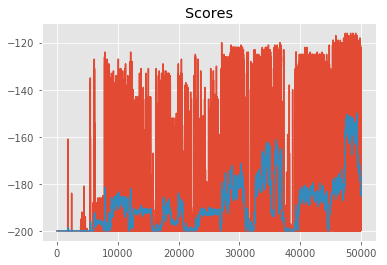

In [42]:
# Train it over a desired number of episodes and analyze scores
# Note: This cell can be run multiple times, and scores will get accumulated
q_agent_new.scores += run(q_agent_new, env, num_episodes=50000)  # accumulate scores
rolling_mean_new = plot_scores(q_agent_new.scores)

[TEST] Completed 100 episodes with avg. score = -175.81


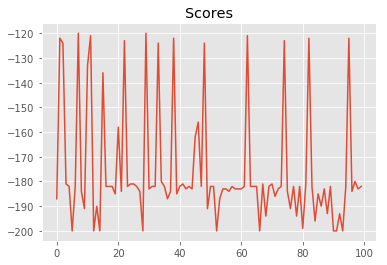

In [43]:
# Run in test mode and analyze scores obtained
test_scores = run(q_agent_new, env, num_episodes=100, mode='test')
print("[TEST] Completed {} episodes with avg. score = {}".format(len(test_scores), np.mean(test_scores)))
_ = plot_scores(test_scores)

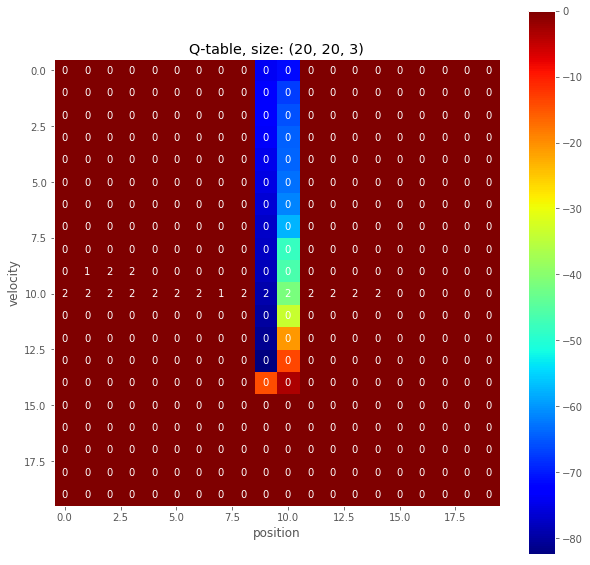

In [44]:
# Visualize the learned Q-table
plot_q_table(q_agent_new.q_table)

### 7. Watch a Smart Agent

In [49]:
state = env.reset()
score = 0
for t in range(200):
    action = q_agent_new.act(state, mode='test')
    env.render()
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        break 
print('Final score:', score)
env.close()

Final score: -182.0
